In [1]:
import os
import json
import requests
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [2]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open("../.env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception as e:
        print(e)
        return None
    
api_key = get_key()

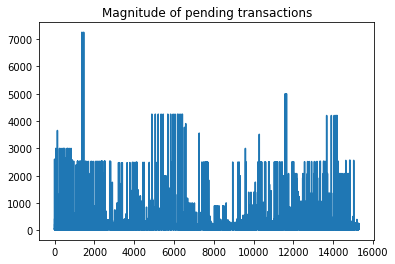

In [58]:
# read in the data from different sources
res1 = pd.read_csv("../data/results_06-06.csv", sep='; ', engine='python')
res2 = pd.read_csv("../data/results_07-08.csv", sep='; ', engine='python')
res3 = pd.read_csv("../data/results_10-12.csv", sep='; ', engine='python')

# join the different data files
results_all = pd.concat([res1, res2, res3])

# change the UNIX timestamp to human readable format and set it as index
results_all["timestamp"] = pd.to_datetime(results_all.timestamp, utc=True)
#results_all.set_index("timestamp", inplace=True)

# get the value of BTC per pending txn
results_all["btc"] = results_all.value // 10**8

# plot just to see if there are lots of whale activity
results_all.btc.plot()
plt.title("Magnitude of pending transactions")
plt.show()

In [6]:
dfs = []
n_days = 7

for i in range(n_days):
    print(f"Iteration: {i}")
    # get the start and end dates in timestamps
    startDate = df.timestamp.min() + timedelta(i-1)
    endDate = startDate + timedelta(1)
    
    # convert to UNIX format
    startDate = str(round(startDate.timestamp()*10**3))
    endDate = str(round(endDate.timestamp()*10**3))

    # the url for our endpoint
    url = "https://web3api.io/api/v2/market/ohlcv/btc_usd/historical"
    
    # our query
    querystring = {
        "timeInterval": "minutes", 
        "timeFormat": "iso",
        'startDate': startDate, 
        'endDate': endDate, 
        "exchange": "bitfinex"
    }
    
    # the API key
    headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

    # the response for our query
    payload = get_response(url, headers, querystring)
    
    # we save the OHLCV data
    bfx = payload['data']['bitfinex']

    # get the columns and make a dataframe
    columns = payload['metadata']['columns']
    bfx_df = pd.DataFrame(bfx, columns=columns)
    # append the dataframe to a list
    dfs.append(bfx_df)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [114]:
# combine the several days of OHLCV data
ohlcv = pd.concat(dfs)

## Working with the OHLCV data

In [115]:
# unify the timestamp format and set as index
ohlcv["timestamp"] = pd.to_datetime(ohlcv.timestamp)

# drop OHL from the dataframe
ohlcv.drop(['open', 'high', 'low'], axis=1, inplace=True)

# select only data from our date range
ohlcv = ohlcv[ohlcv.timestamp <= df.timestamp.max()]
ohlcv = ohlcv[ohlcv.timestamp >= df.timestamp.min()]

### Adding USD to Pending txns

In [116]:
results_all["ts_minute"] = results_all.timestamp.dt.round('1min')

ohlcv.rename({"timestamp": "ts_minute"}, axis=1, inplace=True)

df_merged = pd.merge(results_all, ohlcv, on = "ts_minute", how='left').dropna()

In [118]:
df_merged["usd"] = df_merged.btc*df_merged.close

In [122]:
df_merged.sort_values("btc", ascending=False)

,timestamp,address,value,btc,ts_minute,close,volume,usd
2824,2020-08-10 17:59:43.711322+00:00,"['15ZvUtAydQGgWWwownPEQddg2xtnrrNVM7', '15ZvUt...",725000008214,7250,2020-08-10 18:00:00+00:00,11888.658444,0.051456,8.619277e+07
7500,2020-08-11 10:30:52.655096+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:31:00+00:00,11719.972916,3.182119,4.984504e+07
7630,2020-08-11 10:40:52.628770+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:41:00+00:00,11712.000000,0.273444,4.981114e+07
6509,2020-08-11 08:00:09.165819+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 08:00:00+00:00,11767.000000,7.768456,5.004505e+07
7404,2020-08-11 10:19:33.374962+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:20:00+00:00,11701.169888,0.032201,4.976508e+07
...,...,...,...,...,...,...,...,...
421,2020-08-08 10:58:24.772780+00:00,"'1PLfTXryE58DdbhTB15vMihN7hrkGmnMh4', '14oEdEs...",1500008655,15,2020-08-08 10:58:00+00:00,11734.977145,0.130000,1.760247e+05
107,2020-08-07 21:41:23.080925+00:00,"'3D8DLi7AR9zsJwHV8BxjfooNaR4dBPHxnz', '3Gbmomi...",1540240941,15,2020-08-07 21:41:00+00:00,11568.000000,0.025000,1.735200e+05
236,2020-08-08 10:14:16.985996+00:00,'3JpHuQbo9VsU5RgzNHqwy3XyfR1iaqFFXG',1530388677,15,2020-08-08 10:14:00+00:00,11721.000000,0.005000,1.758150e+05
737,2020-08-08 11:37:57.685478+00:00,'327r6SqtqXUqPAaDV9Em6gbxiP69ygPZvy',1577791125,15,2020-08-08 11:38:00+00:00,11735.095034,0.354057,1.760264e+05


## Plotting whale activity on price

In [71]:
a1, b1 = res1.timestamp.min(), res1.timestamp.max()
a2, b2 = res2.timestamp.min(), res2.timestamp.max()
a3, b3 = res3.timestamp.min(), res3.timestamp.max()

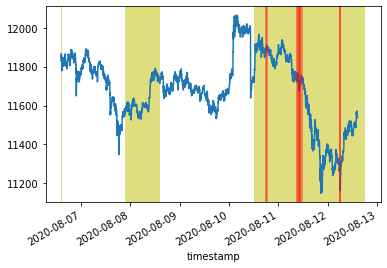

In [74]:
data_sorted = df.sort_values("value", ascending=False)

ohlcv.close.plot()
for i in range(10):
    plt.axvline(data_sorted.iloc[i, 0], color='r', alpha=0.5)
    
plt.axvspan(a1, b1, color='y', alpha=0.5, lw=0)
plt.axvspan(a2, b2, color='y', alpha=0.5, lw=0)
plt.axvspan(a3, b3, color='y', alpha=0.5, lw=0)
plt.show()

In [ ]:
# save current data to csv
ohlcv.to_csv("../data/ohlcv.csv", index=False)
results_all.to_csv("../data/results_all.csv", index=False)